In [37]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
from tqdm import trange
from operator import itemgetter
import numpy as np
from pprint import pprint
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from imageio import imread
from wordcloud import WordCloud

gridc = (1., 1., 1)
plt.rcParams['grid.color'] = gridc
plt.rcParams["axes.edgecolor"] = (0.898, 0.925, 0.965, 1)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
sns.set(style='darkgrid', context='talk', palette='colorblind')

from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>div#site { height: 100% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_path = '../data/'
venue_short = 'iclr2022'
date = '20221101'
df = pd.read_csv(f'{data_path}{venue_short}_{date}.csv')

# get average rating for each paper from ratings column
df['ratings_avg'] = df['ratings'].apply(lambda x: np.mean(eval(x)))
df['ratings_std'] = df['ratings'].apply(lambda x: np.std(eval(x)))
df['confidence_avg'] = df['confidences'].apply(lambda x: np.mean(eval(x)))
df['confidence_std'] = df['confidences'].apply(lambda x: np.std(eval(x)))

In [3]:
df.head()

,id,title,keywords,ratings,confidences,withdraw,decision,review_lengths,ratings_avg,ratings_std,confidence_avg,confidence_std
0,g1SzIRLQXMM,Wiring Up Vision: Minimizing Supervised Synapt...,"['computational neuroscience', 'primate visual...","[8, 8, 8, 8]","[4, 4, 4, 3]",0,Accept (Spotlight),"[493, 788, 460, 460]",8.00,0.000000,3.75,0.433013
1,HndgQudNb91,Learning to Downsample for Segmentation of Ult...,"['ultra-high resolution image segmentation', '...","[8, 6, 6, 6]","[3, 3, 2, 3]",0,Accept (Poster),"[318, 551, 275, 210]",6.50,0.866025,2.75,0.433013
2,7fFO4cMBx_9,Variational Neural Cellular Automata,"['Neural Cellular Automata', 'Cellular Automat...","[5, 8, 5, 5]","[4, 5, 4, 4]",0,Accept (Poster),"[434, 1113, 463, 338]",5.75,1.299038,4.25,0.433013
3,FKp8-pIRo3y,Wish you were here: Hindsight Goal Selection f...,"['goal-conditioned reinforcement learning', 'l...","[6, 6, 6, 6]","[4, 4, 3, 3]",0,Accept (Poster),"[294, 677, 604, 316]",6.00,0.000000,3.50,0.500000
4,KntaNRo6R48,L0-Sparse Canonical Correlation Analysis,[],"[6, 6, 6, 6]","[3, 4, 5, 4]",0,Accept (Poster),"[262, 284, 265, 425]",6.00,0.000000,4.00,0.707107


### Keywords

In [4]:
# Get list
df['keywords'] = df['keywords'].apply(eval)

data = df['keywords']
keywords = {}
for kw in data:
    kw = [_k.lower().strip() for _k in kw]
    for _k in kw:
        if _k in keywords.keys():
            keywords[_k] += 1
        else:
            keywords[_k] = 1
# sort values
keywords = {k: v for k, v in sorted(keywords.items(), key=lambda item: item[1])[::-1]}
keywords = pd.Series(keywords).sort_values(ascending=True)
# sort keyword

<AxesSubplot:title={'center':'ICLR 2023 Submission Top 50 Keywords'}>

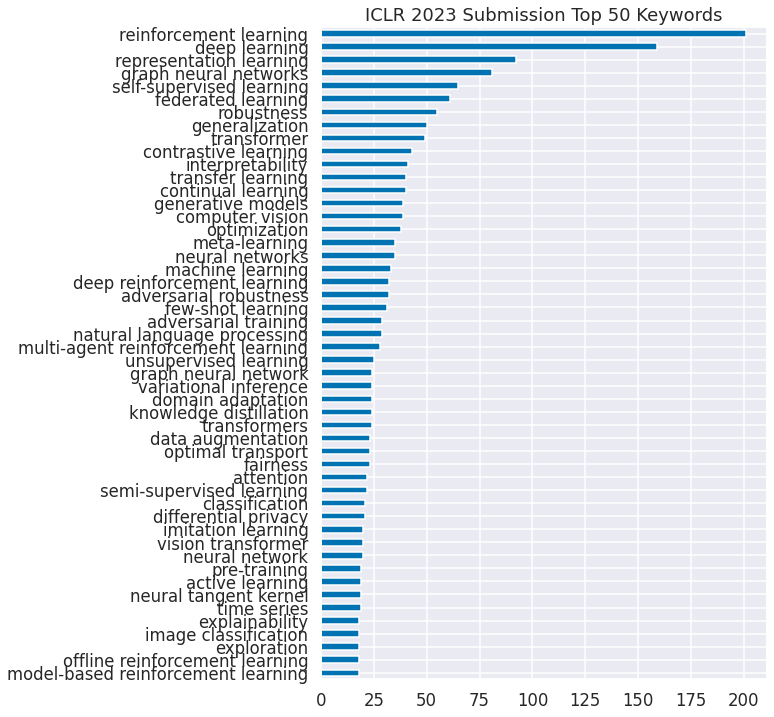

In [5]:
keywords.iloc[-50:].plot.barh(figsize=(8, 12), title='ICLR 2023 Submission Top 50 Keywords')


(-0.5, 1279.5, 639.5, -0.5)

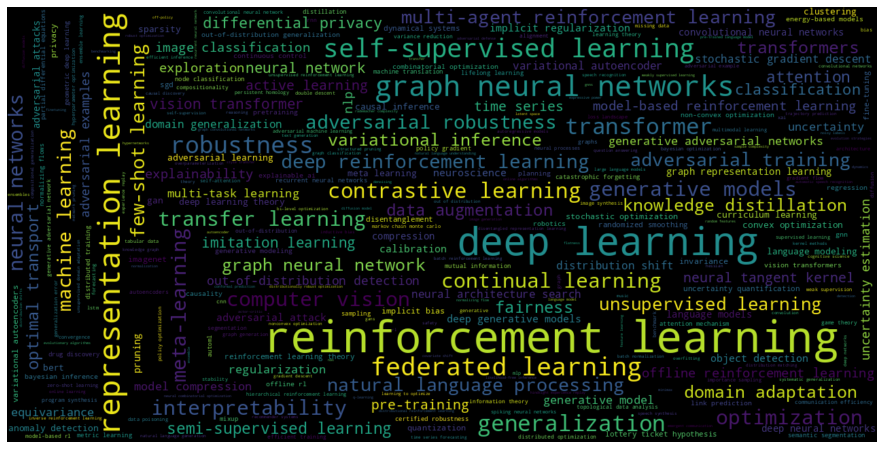

In [6]:
from imageio import imread
from wordcloud import WordCloud

wc = WordCloud(background_color="black", max_words=300, max_font_size=64, 
               width=1280, height=640, random_state=0)
wc.generate_from_frequencies(keywords.to_dict())
fig = plt.figure(figsize=(16, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

/tmp/ipykernel_163099/1341546200.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  logo = imread('../assets/ICLR-mask.png')


(-0.5, 998.5, 272.5, -0.5)

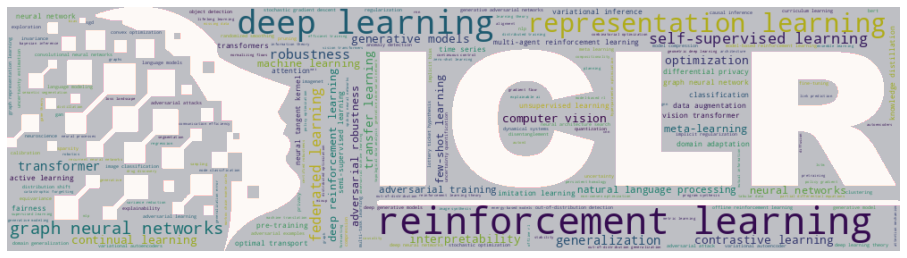

In [7]:
logo = imread('../assets/ICLR-mask.png')
wc = WordCloud(background_color="white", max_words=300, max_font_size=64, 
               width=1280, height=640, random_state=0, mask=logo, contour_color='black')
wc.generate_from_frequencies(keywords.to_dict())
fig = plt.figure(figsize=(16, 8))
plt.imshow(logo)
plt.imshow(wc, interpolation="bilinear", alpha=.75)
plt.axis("off")

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


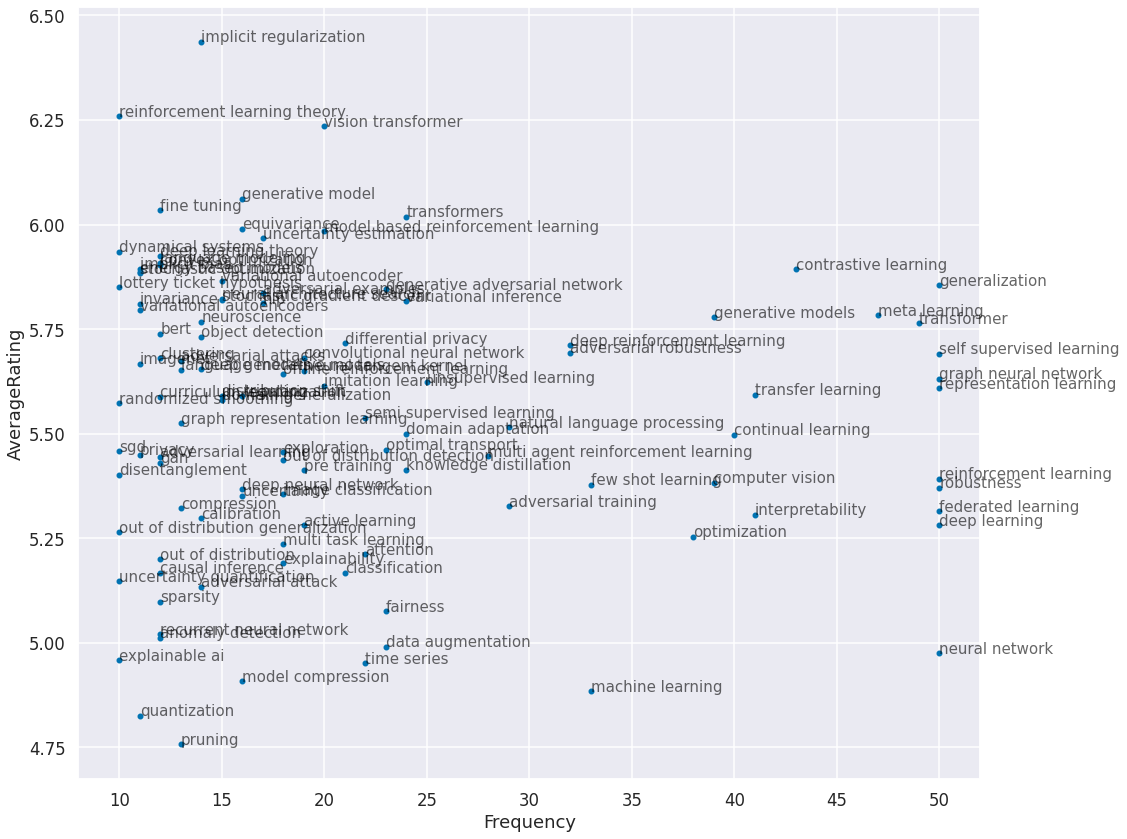

In [8]:
data = {}
for keywords, rating in zip(df.keywords, df.ratings_avg):
    if (isinstance(keywords, float) and np.isnan(keywords)) or np.isnan(rating):
        continue
    for keyword in keywords:
        data.setdefault(keyword.lower().replace('-', ' ').replace('networks', 'network').strip(), []).append(rating)

t = pd.DataFrame({
    'Frequency': [min(len(v), 50) for v in data.values()], # clip to 50
    'AverageRating': [np.mean(v) for v in data.values()],
    'Keyword': list(data.keys())
}).query('Frequency>9')
t.plot.scatter(x='Frequency', y='AverageRating', figsize=(16, 12))

for i in range(len(t)):
     plt.text(t.Frequency.iloc[i], t.AverageRating.iloc[i], t.Keyword.iloc[i], 
              horizontalalignment='left', 
              size='small', color='black', alpha=0.6)

plt.tight_layout()

### Statistics

In [9]:
# all decisions
_cmd = "SELECT rating_0_avg, rating_3_avg FROM submissions;"

data = df['ratings_avg']
rating_avgs = np.array(data).transpose()
print("\n> Total submissions (including the withdraw): {}".format(len(data)))
print(f"  Avg: {rating_avgs.mean():.2f} ± {rating_avgs.std():.2f}")

# oral
data = df[df['decision'].str.contains('Oral')]['ratings_avg']
oral_avgs = np.array(data).transpose()
print("\n> Oral submissions: {}".format(oral_avgs.shape))
print(f"  Avg oral: {oral_avgs.mean():.2f} ± {oral_avgs.std():.2f}")

# spotlight
data = df[df['decision'].str.contains('Spotlight')]['ratings_avg']
spotlight_avgs = np.array(data).transpose()
print("\n> Spotlight submissions: {}".format(spotlight_avgs.shape))
print(f"  Avg spotlight: {spotlight_avgs.mean():.2f} ± {spotlight_avgs.std():.2f}")


# poster
data = df[df['decision'].str.contains('Poster')]['ratings_avg']
poster_avgs = np.array(data).transpose()
print("\n> Poster submissions: {}".format(poster_avgs.shape))
print(f"  Avg poster: {poster_avgs.mean():.2f} ± {poster_avgs.std():.2f}")

# all accepted
# select all accepted papers: where withdraw is 0 and decision is not Reject
data = df[(df['withdraw'] == 0) & (df['decision'] != 'Reject')]['ratings_avg']
accepted_avgs = np.array(data).transpose()
print("\n> Accepted submissions: {}".format(accepted_avgs.shape))
print(f"  Avg accepted: {accepted_avgs.mean():.2f} ± {accepted_avgs.std():.2f}")

# reject
data = df[df['decision'].str.contains('Reject')]['ratings_avg']
reject_avgs = np.array(data).transpose()
print("\n> Reject submissions: {}".format(reject_avgs.shape))
print(f"  Avg reject: {reject_avgs.mean():.2f} ± {reject_avgs.std():.2f}")


> Total submissions (including the withdraw): 2628
  Avg: 5.52 ± 1.29

> Oral submissions: (55,)
  Avg oral: 7.81 ± 0.64

> Spotlight submissions: (174,)
  Avg spotlight: 7.34 ± 0.57

> Poster submissions: (865,)
  Avg poster: 6.41 ± 0.60

> Accepted submissions: (1094,)
  Avg accepted: 6.63 ± 0.74

> Reject submissions: (1534,)
  Avg reject: 4.72 ± 0.97


2628
Rejct: 1534
Poster: 865
Spotlight: 174
Oral: 55


Text(0.5, 1.0, 'ICLR 2022 Rating Distribution')

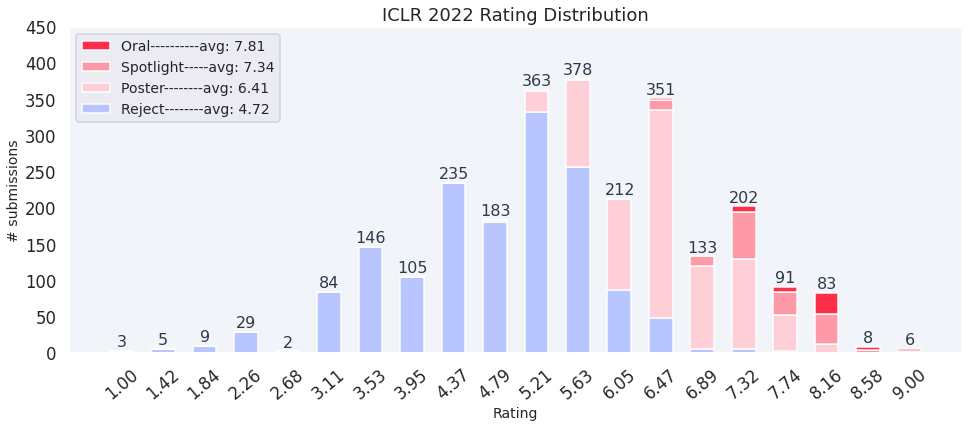

In [10]:
data = df[df['withdraw'] == 0]['ratings_avg']
rating_avgs = np.array(data)
_min, _max = rating_avgs.min(), rating_avgs.max()

width = 0.24
fig = plt.figure(figsize=[16, 6], frameon=False)

ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor((0.898, 0.925, 0.965, 0.5))
ax.spines['left'].set_color('w')
ax.spines['bottom'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['top'].set_color('w')

# all submissions
hist, bin_edges = np.histogram(rating_avgs, bins=20, range=(_min, _max))
# ax.bar(np.linspace(_min, _max, len(hist)), hist, width=width, alpha=0.95, 
#        color='#789BFF', capsize=4)
print(sum(hist))
for i, v in zip(np.linspace(_min, _max, len(hist)), hist):
    ax.text(i - 0.05 * len(str(v)), v + 6.0, str(v), color='#2f3a49', fontsize=16)

# reject
hist_reject, _ = np.histogram(reject_avgs, bins=20, range=(_min, _max))
print(f"Rejct: {sum(hist_reject)}")
ax.bar(np.linspace(_min, _max, len(hist)), hist_reject, width=width, alpha=0.95, 
       color='#B6C3FF', capsize=4, label=f'{"Reject":-<14}avg: {reject_avgs.mean():.2f}')

# poster
hist_poster, _ = np.histogram(poster_avgs, bins=20, range=(_min, _max))
print(f"Poster: {sum(hist_poster)}")
ax.bar(np.linspace(_min, _max, len(hist)), hist_poster, bottom=hist_reject, width=width, alpha=0.95, 
       color='#ffced6', capsize=4, label=f'{"Poster":-<14}avg: {poster_avgs.mean():.2f}')

# spotlight
hist_spotlight, _ = np.histogram(spotlight_avgs, bins=20, range=(_min, _max))
print(f"Spotlight: {sum(hist_spotlight)}")
ax.bar(np.linspace(_min, _max, len(hist)), hist_spotlight, bottom=hist_poster + hist_reject, 
       width=width, alpha=0.95, 
       color='#FF95A4', capsize=4, label=f'{"Spotlight":-<14}avg: {spotlight_avgs.mean():.2f}')

# oral
hist_oral, _ = np.histogram(oral_avgs, bins=20, range=(_min, _max))
print(f"Oral: {sum(hist_oral)}")
ax.bar(np.linspace(_min, _max, len(hist)), hist_oral, bottom=hist_poster + hist_reject + hist_spotlight, 
       width=width, alpha=0.95, 
       color='#FF2542', capsize=4, label=f'{"Oral":-<14}avg: {oral_avgs.mean():.2f}')

plt.ylim(0, 450)
plt.xticks(ticks=np.linspace(_min, _max, len(hist)), 
           rotation=40, 
           labels=[f"{d:.2f}" for d in np.linspace(_min, _max, len(hist))])
ax.set_ylabel(r"# submissions", fontsize=14)
ax.set_xlabel("Rating", fontsize=14)
ax.set_axisbelow(True)
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc=2, fontsize=14)
plt.title('ICLR 2022 Rating Distribution')
# plt.savefig('../images/stats_bar_0130.png')

In [35]:
def flatten(l):
    return [item for sublist in l for item in sublist]

# Convert to list of int via eval
review_lengths = flatten(df['review_lengths'].apply(lambda x: eval(x)).tolist())
ratings = flatten(df['ratings'].apply(lambda x: eval(x)).tolist())
confidences = flatten(df['confidences'].apply(lambda x: eval(x)).tolist())

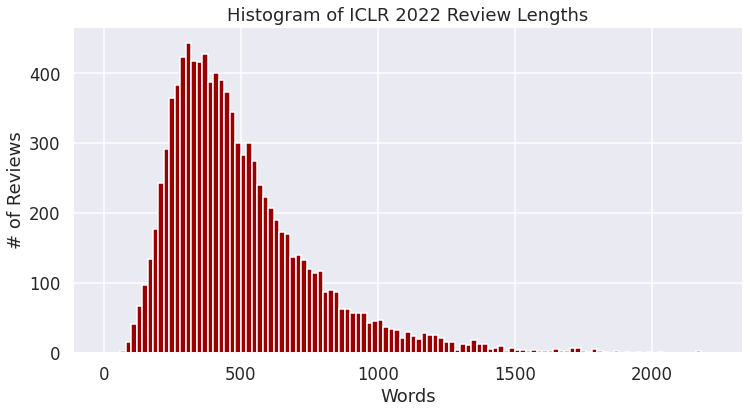

In [36]:
# Plot histograms of review len
fig = plt.figure(figsize=(12, 6))
plt.title('Histogram of ICLR 2022 Review Lengths')


# Review length hist (remove the 10 shortest/longest reviews)
interval = 20
all_review_len_sorted_clip = sorted(review_lengths)[10:-10]
plt.hist(all_review_len_sorted_clip, bins=[v*interval for v in list(
    np.array(range(np.max(all_review_len_sorted_clip)//interval)))],
    color='#990000')
plt.xlabel('Words')
plt.ylabel('# of Reviews')
plt.show()

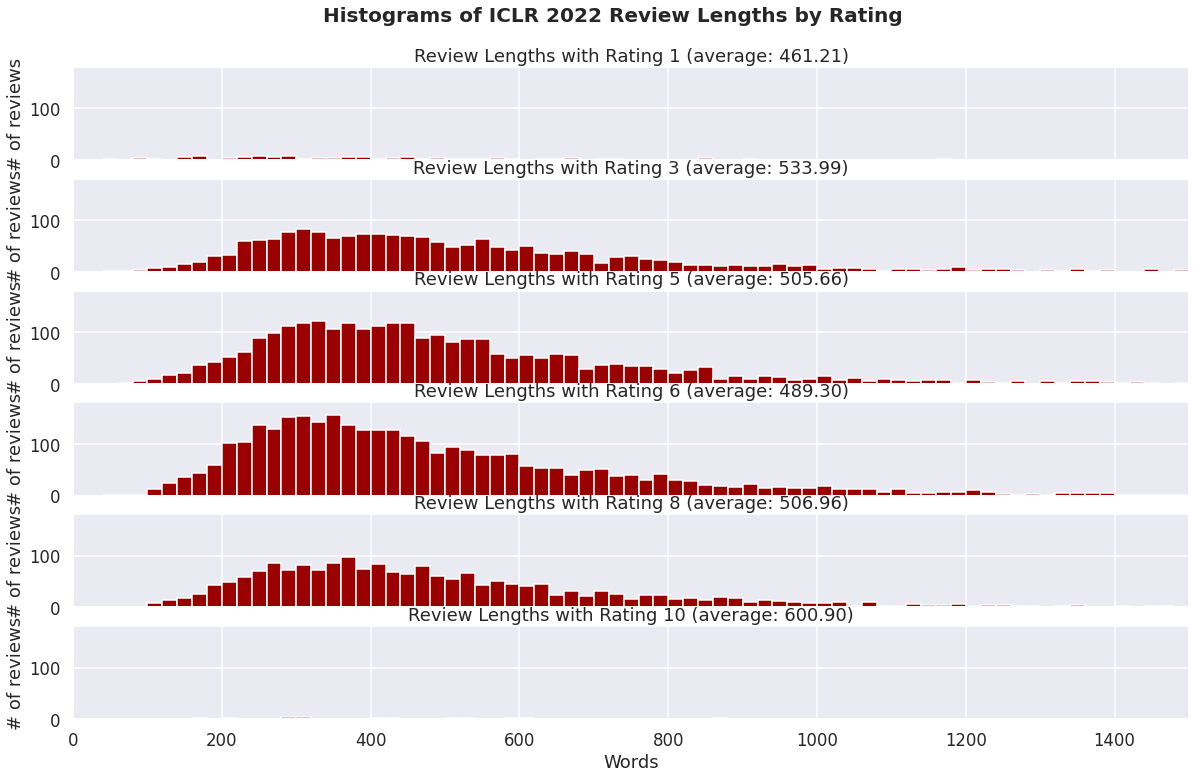

In [48]:
unique_ratings = np.unique(ratings)
bins = [v*interval for v in list(np.array(range(np.max(review_lengths)//interval)))]
gs = gridspec.GridSpec(len(unique_ratings), 1) 
fig = plt.figure(figsize=(20, 12))
for i, unique_rating in enumerate(unique_ratings):
    plt.subplot(gs[i])
    # Plot histograms of review len
    
    # Review length hist
    all_review_len_rating = []
    for j, r in enumerate(ratings):
        if r == unique_rating:
            all_review_len_rating.append(review_lengths[j])
            
    plt.title('Review Lengths with Rating {} (average: {:.2f})'.format(
        unique_rating, np.mean(all_review_len_rating)))
    
    plt.hist(all_review_len_rating, bins=bins, color='#990000')
    if i == len(unique_ratings)-1:
        plt.xlabel('Words')
    else:
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off    
    plt.ylim(0, 180)
    plt.xlim(0, 1500)     
    plt.ylabel('# of reviews')   
fig.suptitle('Histograms of ICLR 2022 Review Lengths by Rating', fontsize=20, fontweight='bold', y=0.95) # or plt.suptitle('Main title')   
plt.show()    


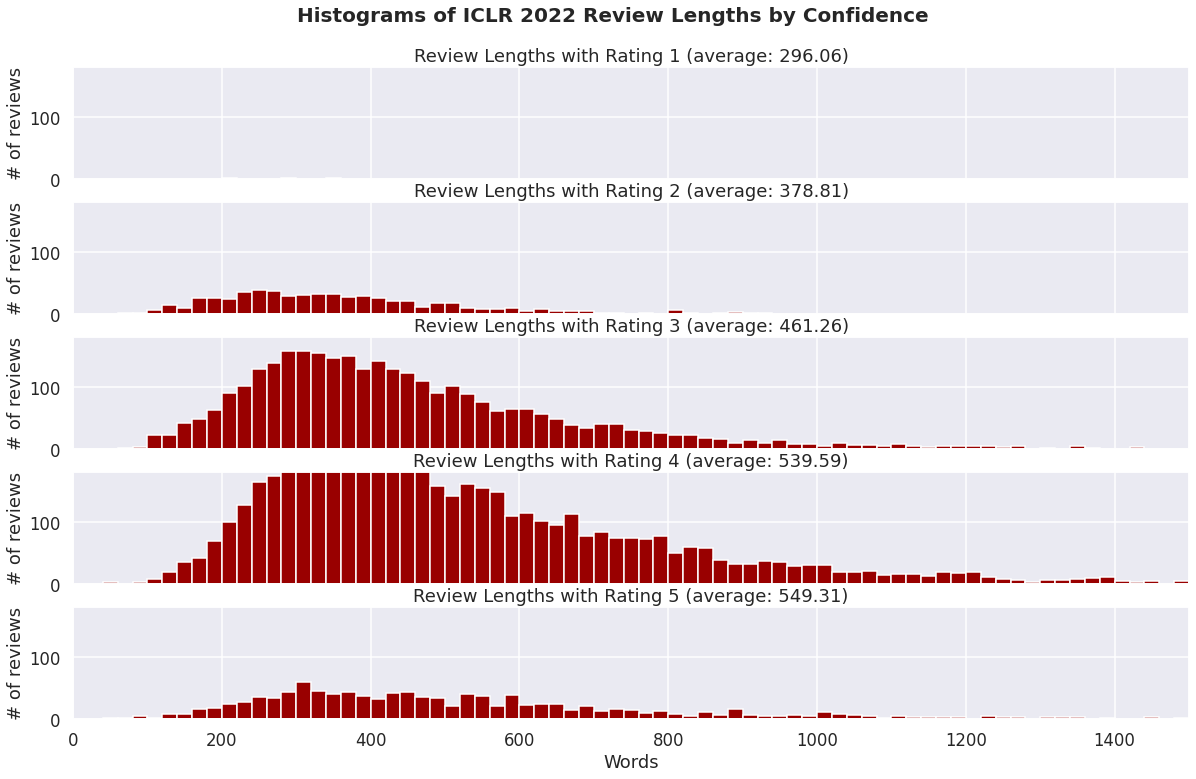

In [49]:
unique_confidences = np.unique(confidences)
bins = [v*interval for v in list(np.array(range(np.max(review_lengths)//interval)))]
gs = gridspec.GridSpec(len(unique_confidences), 1) 
fig = plt.figure(figsize=(20, 12))
for i, unique_rating in enumerate(unique_confidences):
    plt.subplot(gs[i])
    # Plot histograms of review len
    
    # Review length hist
    all_review_len_rating = []
    for j, r in enumerate(confidences):
        if r == unique_rating:
            all_review_len_rating.append(review_lengths[j])
            
    plt.title('Review Lengths with Rating {} (average: {:.2f})'.format(
        unique_rating, np.mean(all_review_len_rating)))
    
    plt.hist(all_review_len_rating, bins=bins, color='#990000')
    if i == len(unique_confidences)-1:
        plt.xlabel('Words')
    else:
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off    
    plt.ylim(0, 180)
    plt.xlim(0, 1500)     
    plt.ylabel('# of reviews')   
fig.suptitle('Histograms of ICLR 2022 Review Lengths by Confidence', fontsize=20, fontweight='bold', y=0.95) # or plt.suptitle('Main title')   
plt.show()    
